# ML model using scorecard data

This notebook explores whether machine learning methods have better predictive abilities than the "traditional" data analytics approach of running a linear regression equation on all *a priori* explanatory variables (features), i.e. the "kitchen-sink" approach. This is done using data from the College Scorecard linked geographically to variables on economic conditions. Both these approaches are correlational in nature. 

It also investigates why the linear model estimated on the whole sample performs better than the linear model using cross-validation.

1. Which outliers are driving high errors
2. What happens to the models when these outliers are dropped
3. How sensitive are the predictions if test scores are dropped from the specifications

In [29]:
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import linear_model
from sklearn import impute
from sklearn.preprocessing import StandardScaler

# For splits and CV
from sklearn.model_selection import train_test_split

# Machine learning methods 
from sklearn.ensemble import RandomForestClassifier as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

import requests
from bs4 import BeautifulSoup
from random import randint
import re
import time
import math
import operator
import numpy as np
import pandas as pd

# Misc
import warnings
warnings.filterwarnings("ignore")

## Read data 

In [30]:
scard_ml = pd.read_pickle('scard_ml.pkl')
ba_ml = scard_ml.loc[scard_ml.PREDDEG == "Predominantly bachelor's"] # scard_ml.query('PREDDEG == "Predominantly bachelor\'s"')
ba_ml[['MD_EARN_WNE_P10', 'ADM_RATE', 'admrate', 'PCTPELL', 'SATVRMID', 'SATMTMID', 'ACTCMMID']].describe()

,MD_EARN_WNE_P10,ADM_RATE,admrate,PCTPELL,SATVRMID,SATMTMID,ACTCMMID
count,1813.000000,1526.000000,1730.000000,1813.000000,1175.000000,1177.000000,1207.000000
mean,50635.338665,0.671263,0.710027,0.383591,566.352340,561.672897,23.634631
std,14132.162734,0.206031,0.220652,0.163538,61.215055,69.437959,3.717855
min,16792.000000,0.000000,0.000000,0.000000,300.000000,370.000000,15.000000
25%,41549.000000,0.558850,0.579400,0.267200,525.000000,515.000000,21.000000
50%,48092.000000,0.692600,0.728200,0.364700,560.000000,550.000000,23.000000
75%,56800.000000,0.825250,0.890500,0.476100,600.000000,590.000000,25.000000
max,132969.000000,1.000000,1.000000,1.000000,760.000000,795.000000,36.000000


### Impute test scores

Impute ACT using linear regression on PCTPELL and admission rate

In [31]:
# Explore regression specifications for imputation

import statsmodels.api as sm

def specRegression(X, y, addConstant = 1): 
    if addConstant == 1:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    return results

print(specRegression(X=ba_ml[['PCTPELL', 'admrate']], y=ba_ml['ACTCMMID']).summary())

                            OLS Regression Results                            
Dep. Variable:               ACTCMMID   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     1166.
Date:                Mon, 09 Jan 2023   Prob (F-statistic):          2.10e-282
Time:                        14:31:33   Log-Likelihood:                -2646.9
No. Observations:                1207   AIC:                             5300.
Df Residuals:                    1204   BIC:                             5315.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4155      0.251    137.147      0.0

In [32]:
def imputeWithLinearRegression(df, X, y):
    imp_data = df[X + y].dropna(axis=0, how='any')
    # Get not in imp_data for prediction
    # See https://stackoverflow.com/questions/29134635/slice-pandas-dataframe-by-index-values-that-are-not-in-a-list
    # for other approaches
    impute_index = set(df.index) - set(imp_data.index) 

    imp_model = linear_model.LinearRegression()
    imp_model.fit(X=imp_data[X], y=imp_data[y])

    pred = df.loc[impute_index][X].dropna()
    predvar = y[0] + '_pred'
    pred[predvar] = imp_model.predict(pred[X])
    df[predvar] = df[y[0]]
    df.loc[impute_index, predvar] = pred[predvar]

    return df

ba_ml = imputeWithLinearRegression(df=ba_ml, X=['PCTPELL', 'admrate'], y=['ACTCMMID'])

In [33]:
# Impute with other approaches to see if there are substantial differences

def otherImputation(df):
    df['ACTCMMID_medfill'] = df['ACTCMMID'].fillna(df['ACTCMMID'].median())
    ACTCMMID_knn = ba_ml[['ACTCMMID', 'admrate', 'PCTPELL']]
    knnImputer = impute.KNNImputer()
    knnImputer.fit(ACTCMMID_knn)
    df['ACTCMMID_knn'] = knnImputer.fit_transform(ACTCMMID_knn)[:,0]
    return df

ba_ml = otherImputation(ba_ml)

In [34]:
ba_ml[['ACTCMMID_medfill', 'ACTCMMID_pred', 'ACTCMMID_knn']].describe()

,ACTCMMID_medfill,ACTCMMID_pred,ACTCMMID_knn
count,1813.000000,1730.000000,1813.000000
mean,23.422504,22.656823,22.977165
std,3.047849,4.121065,3.680956
min,15.000000,9.396285,15.000000
25%,22.000000,20.000000,20.200000
50%,23.000000,22.298597,22.000000
75%,24.000000,25.000000,25.000000
max,36.000000,36.000000,36.000000


For now, this is the only variable we will impute. Drop the other test variables as well as unneeded columns from the data frame.

In [35]:
ba_ml.drop(axis = 1, columns = ['SATVRMID', 'SATMTMID', 'ACTCMMID', 'ACTMTMID', 'OPENADMP', 'PREDDEG', 'UNITID', 'OPEID', 'OPEID6', 'MAIN', 
'ICLEVEL', 'C150_L4', 'ST_FIPS', 'CONTROL', 'HIGHDEG', 'ADM_RATE', 'RET_FTL4', 'MD_EARN_WNE_P8', 'MD_EARN_WNE_P6'], inplace = True)
ba_ml = ba_ml.dropna()
ba_ml_1819 = ba_ml.copy()

## "Traditional" analytics approach

This approach estimates a linear model using various characteristics and compares R-squares. As a baseline for ML models, a "benchmark" RMSE is computed. This is the RMSE that ML models have to beat.

In [36]:
inst_qual = ['AVGFACSAL', 'PFTFAC']
inst_ugdschar = ['PCTPELL', 'UGDS_WOMEN', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA'] # left out 'UGDS_MEN',  UGDS_UNKN
inst_char = ['admrate', 'C150_4', 'RET_FT4', 'Private for-profit', 'Private nonprofit', 'Public', 'hasGradSchool']
inst_major = ['major_stem_quant', 'major_stem_nonquant', 'major_business', 'major_ahla', 'major_career', 'major_ts']
ccbasic = ['ccbasic_' + str(i) for i in range(15,34)] # only applies to bachelor's and higher
test_scores = ['ACTCMMID_pred', 'ACTCMMID_medfill', 'ACTCMMID_knn']
econ_var = ['urate', 'povrate', 'median_hh_inc']

### Correlation of explanatory variables

In [37]:
corr = pd.DataFrame(ba_ml[inst_char[0:3] + inst_qual + inst_ugdschar + inst_major + test_scores + econ_var].corr())
corr.style.background_gradient(cmap = 'coolwarm', axis=None).set_precision(2)

,admrate,C150_4,RET_FT4,AVGFACSAL,PFTFAC,PCTPELL,UGDS_WOMEN,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,major_stem_quant,major_stem_nonquant,major_business,major_ahla,major_career,major_ts,ACTCMMID_pred,ACTCMMID_medfill,ACTCMMID_knn,urate,povrate,median_hh_inc
admrate,1.00,-0.45,-0.35,-0.42,-0.18,0.27,0.04,0.06,0.07,0.03,-0.30,0.08,0.09,-0.10,-0.27,-0.13,-0.20,0.14,-0.01,0.11,0.09,-0.55,-0.40,-0.52,-0.05,-0.02,-0.04
C150_4,-0.45,1.00,0.75,0.61,0.24,-0.64,-0.04,0.28,-0.43,-0.06,0.37,-0.15,-0.09,0.13,0.27,0.23,0.27,-0.21,-0.03,-0.07,-0.17,0.76,0.66,0.77,-0.08,-0.13,0.19
RET_FT4,-0.35,0.75,1.00,0.58,0.23,-0.58,-0.09,0.22,-0.39,0.01,0.37,-0.13,-0.08,0.10,0.25,0.27,0.22,-0.22,-0.01,-0.04,-0.18,0.69,0.58,0.68,-0.01,-0.07,0.17
AVGFACSAL,-0.42,0.61,0.58,1.00,0.14,-0.51,-0.03,-0.06,-0.26,0.14,0.60,-0.10,-0.03,0.21,0.31,0.43,0.18,-0.08,-0.18,-0.05,-0.13,0.70,0.65,0.71,0.00,-0.09,0.28
PFTFAC,-0.18,0.24,0.23,0.14,1.00,-0.19,-0.13,0.19,-0.09,-0.17,-0.05,0.05,-0.06,0.06,0.03,0.09,0.21,-0.16,0.09,-0.04,0.00,0.24,0.16,0.23,0.02,0.13,-0.26
PCTPELL,0.27,-0.64,-0.58,-0.51,-0.19,1.00,0.10,-0.51,0.62,0.19,-0.22,0.07,0.07,-0.18,-0.28,-0.25,-0.13,0.09,0.12,0.09,0.08,-0.82,-0.57,-0.76,0.17,0.18,-0.14
UGDS_WOMEN,0.04,-0.04,-0.09,-0.03,-0.13,0.10,1.00,-0.15,0.16,0.06,0.01,0.01,0.03,0.02,-0.11,-0.41,0.10,-0.05,-0.20,-0.12,0.45,-0.10,-0.12,-0.12,-0.00,0.03,0.02
UGDS_WHITE,0.06,0.28,0.22,-0.06,0.19,-0.51,-0.15,1.00,-0.64,-0.49,-0.32,-0.08,-0.16,-0.02,-0.20,-0.04,0.02,-0.11,0.11,-0.08,0.05,0.30,0.16,0.26,-0.15,-0.11,-0.18
UGDS_BLACK,0.07,-0.43,-0.39,-0.26,-0.09,0.62,0.16,-0.64,1.00,-0.14,-0.20,-0.05,-0.05,-0.21,-0.16,-0.11,-0.02,0.17,-0.05,0.04,0.06,-0.49,-0.35,-0.45,0.14,0.19,-0.10
UGDS_HISP,0.03,-0.06,0.01,0.14,-0.17,0.19,0.06,-0.49,-0.14,1.00,0.25,-0.01,0.11,0.01,0.04,0.01,0.03,0.02,-0.04,0.07,-0.04,-0.12,-0.06,-0.11,0.07,-0.01,0.19


1. Not surprisingly the imputed values of ACT scores are highly positively correlated among one another
2. The test scores are also positively correlated with faculty salary and graduation rates although not too highly
3. The test scores are highly negatively correlated with percentage of Pell grant recipients - less so for the test score that is filled by medians since percentage of Pell Grant recipients was not used as a predictor in the imputation.
4. The share of Pell Grant recipients is highly correlated with the share of black undergraduates.
5. County unemployment rates are highly correlated with state unemployment rates.

### Linear model specification

Based on the above correlations, a linear model with one test score is used.

In [38]:
linearSpec = specRegression(X = ba_ml[inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]]+ econ_var],
y = ba_ml['MD_EARN_WNE_P10'], addConstant=0)

linearSpec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     136.6
Date:                Mon, 09 Jan 2023   Prob (F-statistic):               0.00
Time:                        14:31:34   Log-Likelihood:                -16568.
No. Observations:                1631   AIC:                         3.322e+04
Df Residuals:                    1587   BIC:                         3.346e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
admrate             -1317.0296   1023.138     -1.287      0.198   -3323.873     689.814
C150_4               7062.6061   1574.757      4.485      0.000    3973.784    1.02e+04
RET_FT4              6142.6362   1909.937      3.216      0.001    2396.371    9888.901
Private for-profit    753.2917   4619.525      0.163      0.870   -8307.721    9814.304
Private nonprofit     876.6793   4559.520      0.192      0.848   -8066.636    9819.995
Public              -2627.8129   4586.216     -0.573      0.567   -1.16e+04    6367.866
ccbasic_15          -5742.5130   1314.325     -4.369      0.000   -8320.509   -3164.517
ccbasic_16          -3513.9837   1208.016     -2.909      0.004   -5883.459   -1144.509
ccbasic_17          -2759.2649   1180.154     -2.338      0.020   -5074.089    -444.441
ccbasic_18          -2265.6038   1085.807     -2.087      0.037   -4395.371    -135.837
ccbasic_19          -1464.2807   1122.614     -1.304      0.192   -3666.243     737.681
ccbasic_20          -3459.6007   1174.474     -2.946      0.003   -5763.285   -1155.917
ccbasic_21          -2242.4241   1140.375     -1.966      0.049   -4479.224      -5.624
ccbasic_22          -2180.4452   1059.121     -2.059      0.040   -4257.868    -103.023
ccbasic_23          -2086.8247   2378.998     -0.877      0.381   -6753.135    2579.485
ccbasic_24          -1765.4882   1634.535     -1.080      0.280   -4971.563    1440.587
ccbasic_25            2.67e-07   1.91e-07      1.399      0.162   -1.07e-07    6.41e-07
ccbasic_26           1.248e+04   1580.271      7.899      0.000    9382.520    1.56e+04
ccbasic_27            1.66e+04   3807.323      4.360      0.000    9130.829    2.41e+04
ccbasic_28           8939.1814   3199.021      2.794      0.005    2664.431    1.52e+04
ccbasic_29          -3672.7739   1886.010     -1.947      0.052   -7372.106      26.558
ccbasic_30           2796.8444   1648.789      1.696      0.090    -437.190    6030.879
ccbasic_31          -3.638e-11   3.85e-11     -0.946      0.344   -1.12e-10    3.91e-11
ccbasic_32          -5297.2852   3253.468     -1.628      0.104   -1.17e+04    1084.263
ccbasic_33          -5364.2794   8508.403     -0.630      0.528   -2.21e+04    1.13e+04
AVGFACSAL               1.6414      0.130     12.598      0.000       1.386       1.897
PFTFAC               -117.6462    716.350     -0.164      0.870   -1522.737    1287.445
PCTPELL             -1.762e+04   2316.111     -7.606      0.000   -2.22e+04   -1.31e+04
UGDS_WOMEN          -9304.6431   1593.856     -5.838      0.000   -1.24e+04   -6178.358
UGDS_WHITE            725.4843   2949.165      0.246      0.806   -5059.185    6510.153
UGDS_BLACK           1770.1771   3010.876      0.588      0.557   -4135.536    7675.890
UGDS_HISP            6609.2881   3159.648      2.092      0.037     411.765    1.28e+04
UGD

1. The model explains 78 percent of the variation in institutional median earnings of its students.
2. However, the model is very likely misspecified as a result of high collinearity among the explanatory variables. The share of races all sum to one as do the share of different racial groups.
3. The county economic conditions are also likely highly correlated. While the poverty rate is not statistically significant, the median household income is. However, the sign on the unemployment rate is counter intuitive - a higher unemployment rate leads to higher earnings..
4. Among the share of races within an institution, only the shares of 2 or more races and American Indian/Alaska Native is not statistically significant.
5. The share of part-time faculty is not statistically significant.
6. The type of institution denoted by the Carnegie Classification is statistically significant in many cases. 

Compute means square error manually and using model residuals

In [39]:
np.sqrt(sum((linearSpec.fittedvalues-ba_ml['MD_EARN_WNE_P10'])**2)/len(ba_ml)), np.sqrt(linearSpec.mse_resid)

(6242.599613447975, 6328.546831970968)

The average error is $6,300.

In [40]:
ba_ml['MD_EARN_WNE_P10'].describe()

count      1631.000000
mean      50629.849785
std       13538.818743
min       21258.000000
25%       41982.000000
50%       48193.000000
75%       56541.500000
max      132969.000000
Name: MD_EARN_WNE_P10, dtype: float64

Given that the mean of the outcome is $51,000, this implies an error of 12 percent. If we use the median of $48,000 as a target then the average error is 13 percent.

Compare fitted versus actual

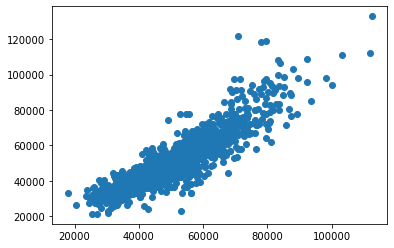

In [41]:
plt.scatter(x = linearSpec.fittedvalues, y = ba_ml['MD_EARN_WNE_P10']);

## How important are test scores in the specification?



In [49]:
linearSpec = specRegression(X = ba_ml[inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + econ_var],
y = ba_ml['MD_EARN_WNE_P10'], addConstant=0)
np.sqrt(sum((linearSpec.fittedvalues-ba_ml['MD_EARN_WNE_P10'])**2)/len(ba_ml)), np.sqrt(linearSpec.mse_resid)

(6291.470211467681, 6376.081742317738)

The average error remains at around $6,300

## Machine learning approach

The ML approach is preferred if the goal is to predict the outcome. The 'traditional' analytics approach uses the entire data set and likely would overfit the model. This implies that the model would not predict well out of sample.

### Preprocessing

In [42]:
def createTrainTest(df, size, rs=402, Xvar=inst_char + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]] + econ_var):
    y = df['MD_EARN_WNE_P10']
    X = df[Xvar]
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=size,random_state=rs)
    scaler = StandardScaler().fit(train_X)
    train_X_std, test_X_std, X_std = scaler.transform(train_X), scaler.transform(test_X), scaler.transform(X)

    return (train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y)

train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml, 0.3)

### ML algorithms

Several machine learning algorithms are considered.
1. Linear models:
    - Linear regression
    - Bayesian ridge regression
    - Ridge regression
    - Lasso
    - Lasso with Least Angle Regression
    - ElasticNet
    - Automatic relevance detection regression
    - Ridge regression with cross validation
2. Survey vector regression
3. Decision tree regressor
4. Nearest neighbor
5. Ensemble methods:
    - Random forest regressor
    - AdaBoost
    - Gradient boosting

In [43]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

def get_cross(model, data, target, groups=10):
    return cross_val_score(model, data, target, cv=groups, scoring='neg_mean_squared_error')

### Using default parameters from sklearn

The algorithms are evaluated in two ways:
1. The error on the hold-out test data set
2. Cross validation error using 10-folds on the entire data set.

As is common practice performance is evaluated using the test data with the cross-validation presented for comparison purposes. Also presented are results using scaled and unscaled features. Since the scale of the features can impact some ML algorithms, results using standardized features are evaluated rather than unscaled features.

In [44]:
# From david paper: Chapter 4 if Hands On Machine Learning Applications: Data Science Fundamentals with Python
from sklearn.ensemble import RandomForestRegressor as rfr, AdaBoostRegressor as ada, GradientBoostingRegressor as gbr
from sklearn.linear_model import LinearRegression as lr, BayesianRidge as bay, Ridge as rr, Lasso as l, LassoLars as ll, ElasticNet as en, ARDRegression as ard, RidgeCV as rcv
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.neighbors import KNeighborsRegressor as knn

regressors = [lr(), 
bay(), 
rr(alpha=.5, random_state=0), 
l(alpha=0.1, random_state=0), 
ll(), 
knn(), 
ard(), 
rfr(random_state=0, n_estimators=100),
SVR(gamma='scale', kernel="linear"),
rcv(fit_intercept=False), 
en(random_state=0),
dtr(random_state=0), 
ada(random_state=0),
gbr(random_state=0)]

def get_error(model, Xtest, ytest):
    y_pred = model.predict(Xtest)
    return np.sqrt(mean_squared_error(ytest, y_pred)), model.__class__.__name__

def getMLresults(trainX, trainY, testX, testY, Type, runType):
    for reg in regressors:
        reg.fit(trainX, trainY)
        # test error
        rmse, name = get_error(reg, testX, testY)
        # cross-validation error using training
        scores = get_cross(reg, trainX, trainY)
        cverr = np.sqrt(np.mean(np.abs(scores)))
        name = reg.__class__.__name__
        results.append({Type: runType, 'method': name, 'error': rmse, 'cverr': cverr})

    return results

results = []
br = '\n'
# print ('unscaled:', br)
results = getMLresults(train_X, train_y, test_X, test_y, 'Scaled', 'No')

# print ('scaled:', br)
results = getMLresults(train_X_std, train_y, test_X_std, test_y, 'Scaled', 'Yes')
results = pd.DataFrame(results)

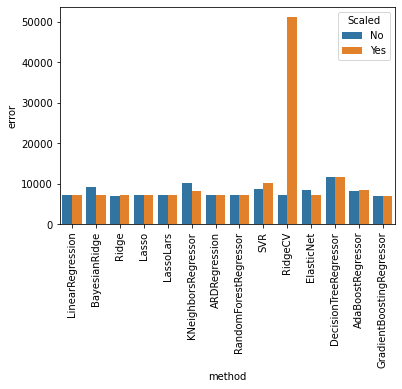

In [45]:
import seaborn as sns

summchart = sns.barplot(x='method', y='error', hue='Scaled', data=results)
summchart.set_xticklabels(rotation=90, labels=summchart.get_xticklabels());

In [46]:
pd.set_option('display.float_format', lambda x: '%8.0f' % x)
results.sort_values(['Scaled','error'], ascending=True).groupby('Scaled').head(30)

,Scaled,method,error,cverr
13,No,GradientBoostingRegressor,6976,6315
2,No,Ridge,7032,6498
6,No,ARDRegression,7079,6511
4,No,LassoLars,7102,6503
9,No,RidgeCV,7183,6638
3,No,Lasso,7187,6515
0,No,LinearRegression,7192,6525
7,No,RandomForestRegressor,7222,6672
12,No,AdaBoostRegressor,8276,7911
10,No,ElasticNet,8412,8305


In all cases, the ML approach does not have a lower RMSE than the traditional analytical approach. As expected the out of sample RMSE for the linear regression is $7,200 which is higher than the traditional approach. Looking at the test errors using scaled data, linear models appear to have similar out of sample errors - the lowest is the ARD regression with an out-of-sample error of $7,100 and the highest is the lasso regression at $7,200. 

Among the ensemble learning approaches, the gradient boosting regressor has the best predictive ability with an out-of-sample error of $7,000 although the difference is small compared to the other regression approaches. Using 10-fold cross-validation on the training data set mostly preserves the ranking of errors computed using the test data. One surprise is the large error using linear regression and cross validation.

One discrepancy of note are the large differences in the scaled versions of the model when errors are computed using cross-validation versus the full data. The error in the linear model and ridge are several times larger. What is the cause of this difference?
